In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def force(r1,r2,m1,m2):
    """
    Calculates the gravitational force on a mass m1 at position r1
    from a mass m2 at position r2
    
    Inputs
    r1        Position of the first mass
    r2        Position of the second mass
    m1        First mass
    m2        Second mass

    Returns
    f_on_m1   Force on m1 as a result of m2    
    """
    # Find r_12 and its magnitude
    r_12 = r2 - r1
    f_on_m1 = (G * m1 * m2)/(np.sqrt(r_12[0]**2 + r_12[1]**2))**3 * r_12
    return f_on_m1

In [3]:
G = 1
m1 = 1
m2 = 3e-6
m3 = 3.6e-8
Ndim = 2     #2D problem for now
Nsteps = 20000
dt = 0.01

r1 = np.zeros((Nsteps, Ndim))
r2 = np.zeros((Nsteps, Ndim))
r3 = np.zeros((Nsteps, Ndim))
v1 = np.zeros((Nsteps, Ndim))
v2 = np.zeros((Nsteps, Ndim))
v3 = np.zeros((Nsteps, Ndim))

# Initial conditions
r2[0] = np.array((1.0, 0))
r3[0] = np.array((1.0, 0.025)) 

v2[0] = np.array((0, np.sqrt(G*m1)))
v3[0] = np.array((-np.sqrt(G*m3/0.025), 0)) + v2[0]


In [4]:
for i in range(Nsteps-1):
    # Finding forces on masses at this timestep
    f2 = force(r2[i], r1[i], m2, m1) + force(r2[i], r3[i], m2, m3)
    f3 = force(r3[i], r2[i], m3, m2) + force(r3[i], r1[i], m3, m1)

    # Updating positions using velocity Verlet
    r2[i+1] = r2[i] + dt*v2[i] + (dt**2)*f2/(2*m2)
    r3[i+1] = r3[i] + dt*v3[i] + (dt**2)*f3/(2*m3)

    # Finding forces at new timestep 
    f2new = force(r2[i+1], r1[i+1], m2, m1) + force(r2[i+1], r3[i+1], m2, m3)
    f3new = force(r3[i+1], r2[i+1], m3, m2) + force(r3[i+1], r1[i+1], m3, m1)

    # Updating velocities using velocity Verlet
    v2[i+1] = v2[i] + dt*((f2+f2new) / (2*m2))
    v3[i+1] = v3[i] + dt*((f3+f3new) / (2*m3))



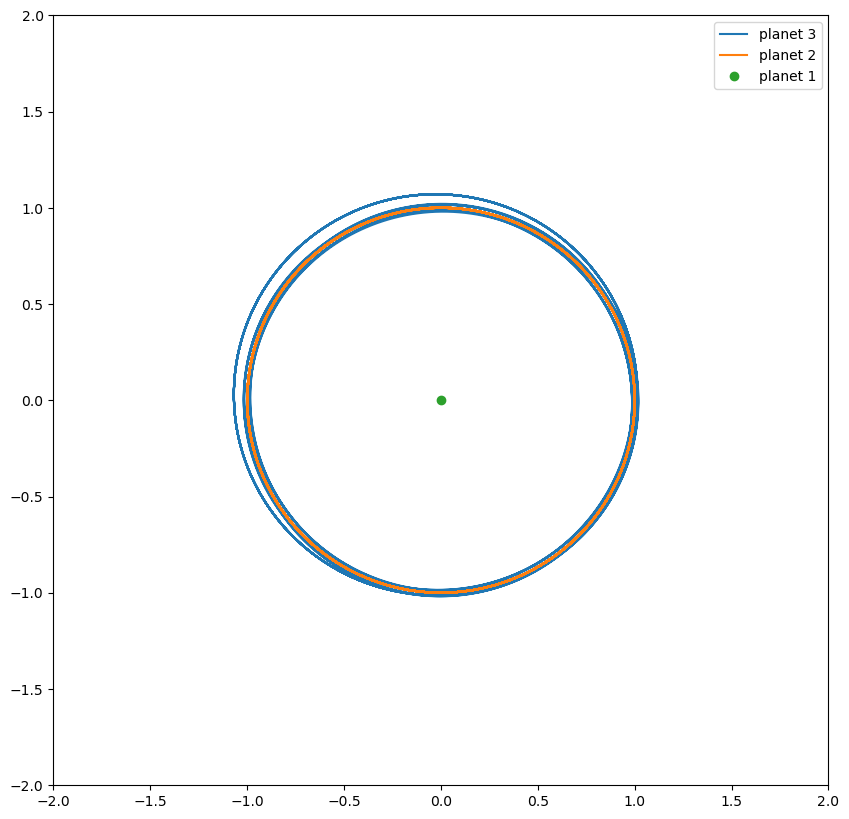

In [5]:
plt.figure(figsize=(10,10))
plt.plot(r3[:,0], r3[:,1], label='planet 3')
plt.plot(r2[:,0], r2[:,1], label='planet 2')
plt.plot(0, 0, 'o', label='planet 1')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.legend()


The initial conditions posed in the specification result in a slight deviation from a circular orbit of planet 3. With that said however, the orbit of planet 2 around 1 is a much better approximation of a circular orbit.

In [42]:
def time_dilation(r1, r2, m1):
    r = np.linalg.norm(r1-r2)
    return np.sqrt(1 - 2*G*m1/(r*3*10**8))

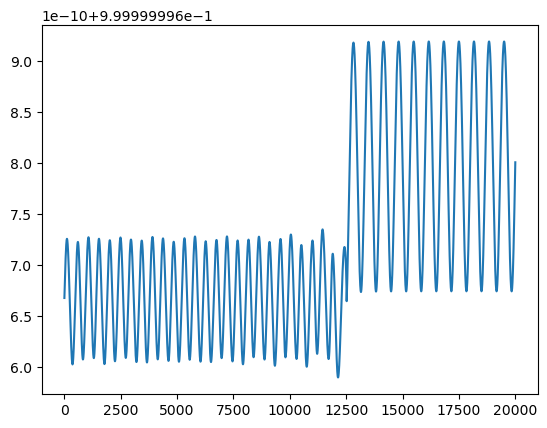

In [44]:
results = np.zeros(len(r1))

for i in range(len(r1)):
    results[i] = time_dilation(r1[i], r3[i], m1)

plt.plot(results)

While interesting enough that we encounter an oscillatory response for time dilation, it is seen that the value spikes towards the end of the simulation. This seems to be due to the inadequate orbital mechnanics, which could be rectified by using a different integrator (Runge Kutta). We proceed as follows.

In [48]:
def RK4_solver(fun,y0,dt,N):
    """Solve dy/dt = fun(y,t) using fourth-order RK method.
    Inputs:
    fun  f(y,t)
    y0   Initial condition - assumed to be two-component
    dt   Step size
    N    Number of steps
    Returns: two arrays of length N+1 (x and v or equivalent)
    """
    # Storage for solution
    y = np.zeros((N+1,2,2))
    # Initial condition
    y[0] = y0
    t = 0
    for i in range(N):
        # RK4 formulae
        k1 = dt*fun(y[i],t)
        k2 = dt*fun(y[i]+0.5*k1,t+0.5*dt)
        k3 = dt*fun(y[i]+0.5*k2,t+0.5*dt)
        k4 = dt*fun(y[i]+k3,t+dt)
        y[i+1]=y[i]+(k1+2*k2+2*k3+k4)/6
        t += dt
    return y

In [76]:
def p2_RHS(y,t):
    m1 = 1.0
    r12 = np.array([0,0]) - y[0]
    r12_mag_cubed = np.linalg.norm(r12)**3

    pos = y[0]
    vel = y[1]
    
    dpos = vel
    dvel = G*m1*r12/r12_mag_cubed

    return np.array([dpos,dvel])

def p3_RHS(y,t):
    m1 = 1
    m2 = 3e-6
    r23 = p2_results[int(t),0] - y[0]
    r23_mag_cubed = np.linalg.norm(r23)**3

    r13 = np.array([0,0]) - y[0]
    r13_mag_cubed = np.linalg.norm(r13)**3

    pos = y[0]
    vel = y[1]
    
    dpos = vel
    dvel = G*m2*r23/r23_mag_cubed + G*m1*r13/r13_mag_cubed

    return np.array([dpos,dvel])

In [77]:
p2_initial_pos = np.array([1,0])
p2_initial_vel = np.array([0,1])

p3_initial_pos = np.array([1,0.0025])
p3_initial_vel = np.array([-np.sqrt(G*m2/0.0025),1])

N = 200
dt = 0.1
p2_y_0 = np.array([p2_initial_pos, p2_initial_vel])
p3_y_0 = np.array([p3_initial_pos, p3_initial_vel])

p2_results = RK4_solver(p2_RHS, p2_y_0, dt, N)
p3_results = RK4_solver(p3_RHS, p3_y_0, dt, N)

print(p2_results[0,0])

[1. 0.]


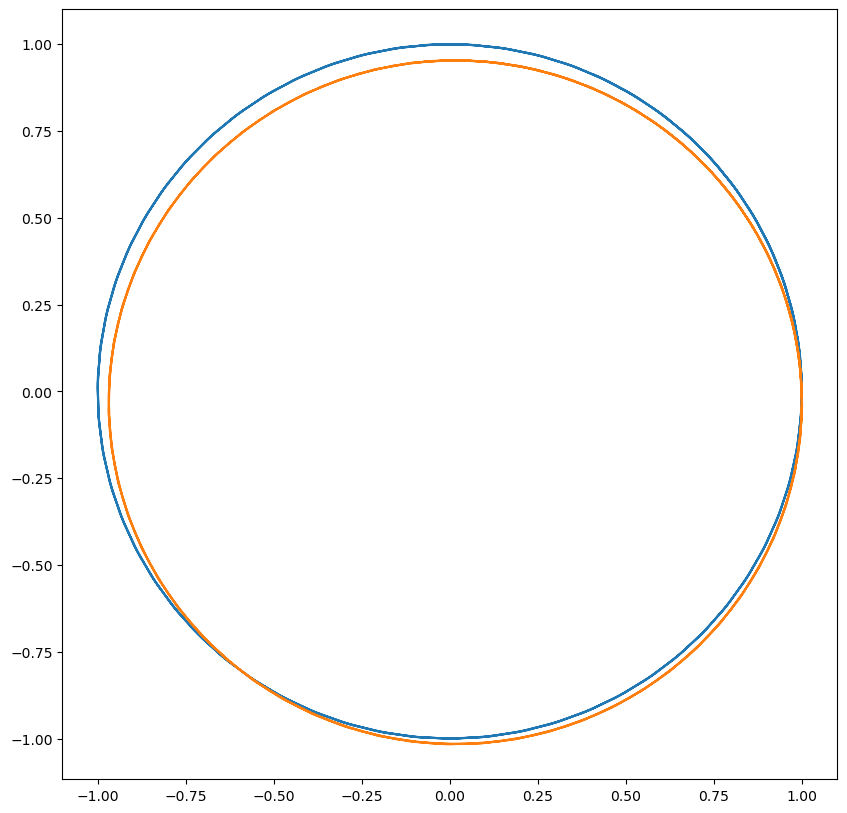

In [78]:
plt.figure(figsize=(10,10))
plt.plot(p2_results[:,0,0], p2_results[:,0,1])
plt.plot(p3_results[:,0,0], p3_results[:,0,1])